In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [25]:
train=pd.read_csv('train.csv',sep='|')

In [26]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [27]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory -> only Logistic Regression for in-depth analysis

In [29]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                     solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                     fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score)
]           
                 
                 
iterations = 10                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                       solver = ['newton-cg', 'lbfgs', 'liblinear'],
                       fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations)
]

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

In [31]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [32]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Time needed", "Raw Model"])


# three types of data preparation: No preparation, MaxMinScaler, StandardScaler
for data_preparation_step in range(1,5):
    if (data_preparation_step == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_step == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_step == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_step == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"      

    for feature_count in range(1,len(list(X))+1):

        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results
            
            start_time = time.time()
            
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]
            
            model.seed = 42
            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]
            
            end_time = time.time()
            
            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(end_time - start_time) + " seconds")

            result_table = result_table.append({
             "Model": model_name,
             "Data Preparation": data_preparation,
             "Feature Count": feature_count,
             "Features": best_feature_list.values,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,
             "Time needed": end_time - start_time,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)
    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Scaling and 1 features after 0.3122115135192871 seconds
Finished LogisticRegression with No Scaling and 2 features after 0.9544568061828613 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Scaling and 3 features after 2.6499340534210205 seconds
Finished LogisticRegression with No Scaling and 4 features after 2.849031686782837 seconds
Finished LogisticRegression with No Scaling and 5 features after 3.2230374813079834 seconds
Finished LogisticRegression with No Scaling and 6 features after 3.1620333194732666 seconds
Finished LogisticRegression with No Scaling and 7 features after 3.6620020866394043 seconds
Finished LogisticRegression with No Scaling and 8 features after 3.5595107078552246 seconds
Finished LogisticRegression with No Scaling and 9 features after 4.831515550613403 seconds
Finished LogisticRegression with No Scaling and 10 features after 4.464727878570557 seconds
Finished LogisticRegression with No Scaling and 11 features after 4.6105077266693115 seconds
Finished LogisticRegression with No Scaling and 12 features after 4.724031209945679 seconds
Finished LogisticRegression with No Scaling and 13 features after 5.1397221088409

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with MinMaxScaler and 3 features after 2.8812355995178223 seconds
Finished LogisticRegression with MinMaxScaler and 4 features after 3.0519778728485107 seconds
Finished LogisticRegression with MinMaxScaler and 5 features after 3.2612130641937256 seconds
Finished LogisticRegression with MinMaxScaler and 6 features after 3.537146806716919 seconds
Finished LogisticRegression with MinMaxScaler and 7 features after 3.7433838844299316 seconds
Finished LogisticRegression with MinMaxScaler and 8 features after 4.318215608596802 seconds
Finished LogisticRegression with MinMaxScaler and 9 features after 4.892958164215088 seconds
Finished LogisticRegression with MinMaxScaler and 10 features after 4.440803527832031 seconds
Finished LogisticRegression with MinMaxScaler and 11 features after 4.555150270462036 seconds
Finished LogisticRegression with MinMaxScaler and 12 features after 4.6408586502075195 seconds
Finished LogisticRegression with MinMaxScaler and 13 features 

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with StandardScaler and 3 features after 2.751437187194824 seconds
Finished LogisticRegression with StandardScaler and 4 features after 2.705860137939453 seconds
Finished LogisticRegression with StandardScaler and 5 features after 2.6915979385375977 seconds
Finished LogisticRegression with StandardScaler and 6 features after 3.308799982070923 seconds
Finished LogisticRegression with StandardScaler and 7 features after 3.877073287963867 seconds
Finished LogisticRegression with StandardScaler and 8 features after 3.9426910877227783 seconds
Finished LogisticRegression with StandardScaler and 9 features after 4.407952785491943 seconds
Finished LogisticRegression with StandardScaler and 10 features after 4.441145896911621 seconds
Finished LogisticRegression with StandardScaler and 11 features after 4.5428431034088135 seconds
Finished LogisticRegression with StandardScaler and 12 features after 4.614470958709717 seconds
Finished LogisticRegression with StandardSca

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
32,LogisticRegression,MinMaxScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.874835,"LogisticRegression(C=1.0, class_weight=None, d..."
71,LogisticRegression,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'lbfgs'}",0.162320,0.119850,8.266583,"LogisticRegression(C=1.0, class_weight=None, d..."
34,LogisticRegression,MinMaxScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,6.746887,"LogisticRegression(C=1.0, class_weight=None, d..."
52,LogisticRegression,StandardScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.151640,"LogisticRegression(C=1.0, class_weight=None, d..."
54,LogisticRegression,StandardScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,6.145855,"LogisticRegression(C=1.0, class_weight=None, d..."
12,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.139722,"LogisticRegression(C=1.0, class_weight=None, d..."
14,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.955201,"LogisticRegression(C=1.0, class_weight=None, d..."
15,LogisticRegression,No Scaling,16,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'lbfgs'}",0.156998,0.120305,9.243658,"LogisticRegression(C=1.0, class_weight=None, d..."
28,LogisticRegression,MinMaxScaler,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.892958,"LogisticRegression(C=1.0, class_weight=None, d..."
48,LogisticRegression,StandardScaler,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.407953,"LogisticRegression(C=1.0, class_weight=None, d..."


In [16]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)
result_table

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
544,LogisticRegression,MinMaxScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.804502,"LogisticRegression(C=1.0, class_weight=None, d..."
832,LogisticRegression,StandardScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.327156,"LogisticRegression(C=1.0, class_weight=None, d..."
192,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.211324,"LogisticRegression(C=1.0, class_weight=None, d..."
864,LogisticRegression,StandardScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.537747,"LogisticRegression(C=1.0, class_weight=None, d..."
1136,LogisticRegression,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'lbfgs'}",0.162320,0.119850,7.004890,"LogisticRegression(C=1.0, class_weight=None, d..."
224,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.044688,"LogisticRegression(C=1.0, class_weight=None, d..."
512,LogisticRegression,MinMaxScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.014032,"LogisticRegression(C=1.0, class_weight=None, d..."
144,LogisticRegression,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.044143,"LogisticRegression(C=1.0, class_weight=None, d..."
464,LogisticRegression,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.086326,"LogisticRegression(C=1.0, class_weight=None, d..."
496,LogisticRegression,MinMaxScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,3.878505,"LogisticRegression(C=1.0, class_weight=None, d..."


Text(0, 0.5, 'Monetary Value Per Instance - Mean')

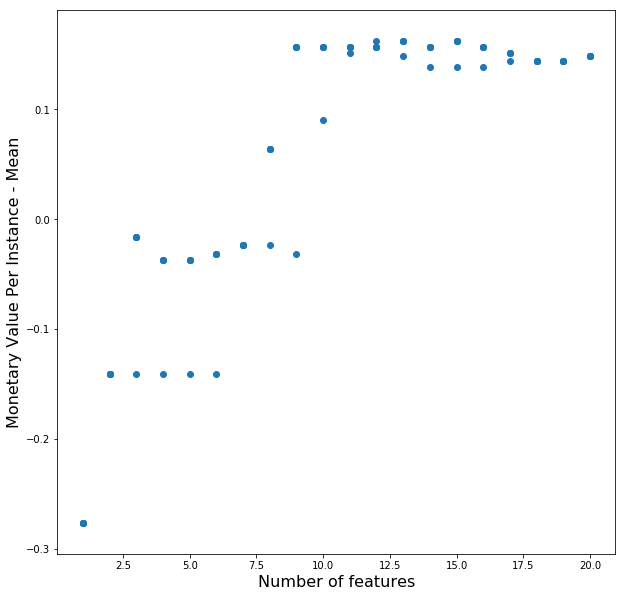

In [35]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [39]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]

print(best_model)
print(best_model_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem' 'lineItemVoidsPerSecond'
 'quantityModificationsPerSecond']


In [40]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm, y_holdout):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(score, 'for ', len(y_holdout), ' instances in the test set')
        print(score/len(y_holdout), ' per instance in the test set')
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm, Y)

True negative:  1770
False positive:  5
False negative:  8
True positive:  96
315 for  1879  instances in the test set
0.16764236295902077  per instance in the test set
